## Overview

One common hallmark of popular machine learning methods is their "black-box" nature.
Since many of these methods are meant solely for prediction, this has not been too much of an issue.
After all, a black box method can be as complex as needed since it does not need to be analyzed after the fact.
This mentality has given birth to increasingly complex but effective models (just take a look at [the model](https://nikcheerla.github.io/deeplearningschool//media/alphago_arch.png) that defeated the worlds best Go player).

However, there has been some recent interest in models that can be understood and analyzed.
This is particularly true in the scientific realm, where practicioners looking to use machine learning would like to get an idea of the mechanisms underlying their system of study.
In order to do so, new tools have been created and old, interpretable tools, such as linear regression, have been adapted to meet this challenge.

Many of these new, interpretable, models have been named "data-driven model discovery."
Their goals is to model collected data from a system with machine learning tools to determine a human-readable model.

## Sparse Identification of Nonlinear Dynamics
One method for model discovery as described above is called Sparse Identification of Nonlinear Dynamics (SINDy)[@brunton2016discovering].
The goal of this method is to extract the most probable differential equation directly from data of the important state variables of a continuum system.

### Setting up linear problem
As its name suggests, this method works discover models for linear or nonlinear systems.
It is based on a simple idea that nonlinear differential equations can be expressed as a linear combination of nonlinear terms[@williams2015data].
Assuming we are looking at the nonlinear time evolution of some quantity, this could then be written as the sum of $K$ nonlinear terms:
$$
u_t(x,t) = \xi_1\mathcal{N}_1(u,x,t) + \ldots + \xi_K\mathcal{N}_K(u,x,t)
$$
If we can then determine what nonlinear terms are possible $\mathcal{N}_i(u,x,t)$, we can sift through these terms to determine which best contribute to the time evolution of the system.

Ultimately, this boils down to a regression problem.
Given some space and time samples of our state variable: $u(x_i,t_j)$ for $i \leq N$ and $j \leq M$, we can consider the linear system:
$$
u_t(x_i,t_j) = \xi_1\mathcal{N}_1(u_{ij},x_i,t_j) + \ldots + \xi_K\mathcal{N}_K(u_{ij},x_i,t_j)
$$
Expanded for all the data samples (flattened across space and time), this can be written as the system:
$$
\begin{bmatrix}
u_t(x_1, t_1) \\
\vdots \\
u_t(x_N, t_1) \\
\vdots \\
u_t(x_N, t_M) \\
\end{bmatrix}
=
\begin{bmatrix}
\mathcal{N}_1(x_1, t_1) & \ldots & \mathcal{N}_K(x_1, t_1) \\
\vdots &  & \vdots \\
\mathcal{N}_1(x_N, t_1) & \ldots & \mathcal{N}_K(x_1, t_1) \\
\vdots &  & \vdots \\
\mathcal{N}_1(x_N, t_M) & \ldots & \mathcal{N}_K(x_1, t_1)
\end{bmatrix}
\vec{\xi}
$$ {#eq-linear-system}

Solving this system is then a straightforward linear regression.

### Determining nonlinear "library" of terms
Determining what $\mathcal{N}_i(u,x,t)$ are reasonable for the system is somewhat of a traditional modeling problem.
Are there any symmetries in the system that need to be satisfied?
Is there periodic behavior that might warrant inclusion of trignometric terms?
What order of polynomial interactions are possible for the system?

The most common library of terms for a 1D function is to put together polynomial interactions with spatial derivatives.
Such a library up to 3rd order polynomials and derivatives could be written:
$$
\begin{align*}
\mathcal{N}_1(u,x,t) &= u\\
\mathcal{N}_2(u,x,t) &= u^2\\
&\vdots \\
\mathcal{N}_i(u,x,t) &= u_x\\
\mathcal{N}_{i+1}(u,x,t) &= u_x^2\\
&\vdots \\
\mathcal{N}_K(u,x,t) &= u^3u_{xxx}\\
\end{align*}
$$

### Numerical differentiation of the terms
In order to actually compute the values in the linear system written in @eq-linear-system, we must compute numerical derivatives in both $t$ and in $x$.
This isn't an issue if we have smooth, reliable data and can be quickly computed with finite differences.

However, the intent of this method is to use data samples $u(x_i,t_j)$ that are collected from the real world, implying that they will each be polluted with some level of noise.
There have been several classical methods presented for dealing with numerical differentiation of noisy data that could be used, but generally the methods revolve around an approximate fitting of a differentiable function basis to the data.
Notable among these are:

- Local polynomial regression (LOESS[@cleveland1988locally], Savitsky-Golay filter[@press1990savitzky], etc.)
- Radial basis functions (Gaussian kernel) 
- Smoothing splines
- Least squares spectral analysis (LSSA)

These can be written along the lines of:
$$
\underset{\vec{c}}{\text{argmin}} \; \sum_{i,j}^{N,M}\|u(x_i,t_j) - F(x_i,t_j,\vec{c})\|_2
$$
where
$$
F(x_i,t_j,\vec{c}) = \sum_l^L c_l \phi_l(x_i,t_j)
$$
and $\phi$ represents our chosen basis function.
Once computed, we can easily approximate derivatives of $u$ via:
$$
u_x(x_i,t_j) \approx F_x(x_i,t_j,\vec{c}) = \sum_l^L c_l \frac{d}{dx}\phi_l(x_i,t_j)
$$



Each of these has the goal of smoothing the given data while simultaneously providing an exact derivative of the approximation.
This is a similar idea as we have discussed with automatic differentiation of neural networks.
In fact, you could consider fitting a neural network to be the same as fitting a randomly initialized nested basis of nonlinear functions (since they are dense according to the universal approximation theorem).
We will explore this idea in the example problem in @sec-simulated.

### Sparse regression
Once the matrix in @eq-linear-system has been created using numerical differentiation, it remains to sift through the nonlinear terms to determine which, if any, contribute to the time evolution of our state variable of interest.
It is usually reasonable to consider that not all the nonlinear terms should be included in the equation, so we would like to determine the most parsimonious (smallest) combination of them that will capture our desired qualitative and quantitative behavior in the system.

There are two main families of sparse regression methods:

**Greedy methods**: Iterative add/remove terms that best match the time derivative in some metric ($R^2$ coefficient of determination, Akaike Information Criteria (AIC), etc.).

- Forward selection: Start with no terms, add one by one according to which maximizes $R^2$ or AIC at each step
- Backward selection: Start with all terms, remove one by one according to which least reduces $R^2$ or AIC
- (Orthogonal) Matching pursuit: Start with no terms, add one by one according to which maximizes correlation (orthogonalizing after each step)

**Regularization methods**: Add a penalty to the regression for having too many terms or large coefficients $\xi_i$.
These can be written roughly as:
$$
\underset{\vec{\xi}}{\text{argmin}}\; \|u_t(x_i,t_j) - \mathbf{\mathcal{N}}(u_{ij},x_i,t_j) \cdot \vec{\xi}\|_2^2 + \lambda \|\xi\|_C
$$

- Ridge regression: Let $C=2$ forcing coefficients $\vec{\xi}$ to be smaller. We hope that important coefficients will remain larger while unimportant ones shrink.
- Lasso regression: Let $C=1$ forcing coefficients $\vec{\xi}$ to be smaller and various to be set to 0 (due to the geometry of the 1-norm).
- 0-norm regression: Let $C=0$ which is a measure that counts the number of nonzero coefficients in $\vec{\xi}$. Computing this usually requires a combination of regularization and relaxation best captured by the SR3 method[@zheng2018unified].

Combinations of these two methods which iterative perform regularization methods removing terms with small coefficients according to a given threshold have also been proposed (Sequential Threshold Ridge Regression[@rudy2017data] or the original SINDy algorithm[@brunton2016discovering]).

### Summary of the method
In summary, the procedure to use SINDy is as follows:

1. Collect sample points of a continuum state variable of interest $u(x_i,t_j)$
2. Form a "library" of possible terms for the differential model of the system $\mathcal{N}_k(u,x,t)$
3. Compute the libary at sample points using noise robust numerical differentiation to compute both $u_t(x_i,t_j)$ and $\mathcal{N}_k(u_{ij},x_i,t_j)$
4. Use sparse regression to determine a sparse vector $\vec{\xi}$ which closely approximates $u_t(x_i,t_j) = \xi_1\mathcal{N}_1(u_{ij},x_i,t_j) + \ldots + \xi_K\mathcal{N}_K(u_{ij},x_i,t_j)$

To really explore this method, we will walk through this process using simulated traveling wave data in @sec-simulated and using real extracted data in @sec-extracted.

## Application to simulated wave data {#sec-simulated}

:::{.callout-note}
For this workshop you will need to install the following packages:

```bash
mamba install numpy matplotlib py-pde sympy jax optax flax scikit-learn scikit-image av
```
:::

Given some data generated via finite differences of the simple advection equation:
$$
h_t(x,t) = h_x(x,t)
$$
with periodic boundaries and a Gaussian initial condition, we have the following measurement of state variable $h$ (height of the wave):


In [1]:
#| code-fold: true
#| code-summary: Generate simple wave data
import numpy as np
import pde
import matplotlib.pyplot as plt

# Domain
xmax = 1.0
nx = 100
dt = 1e-6
tmax = 1.0-2*dt
save_dt = 0.01
init_cond = ".1*exp(-(1/.01)*(x-0.3)**2)"

grid = pde.CartesianGrid([(0.0,xmax)],nx,periodic=True)
h = pde.ScalarField.from_expression(grid,init_cond,label="h(x,t)")
eq = pde.PDE({"h": "-d_dx(h)"})
storage = pde.MemoryStorage()

result = eq.solve(h,t_range=tmax,dt=dt,tracker=storage.tracker(save_dt),ret_info=False)

# pde.plot_kymograph(storage)
movie = pde.visualization.movie(storage,"simple_wave.gif")

h=np.array(storage.data)
x=storage.grid.coordinate_arrays[0]
t=np.array(storage.times)
np.savez("simple_wave.npz",h=h,x=x,t=t)
plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

![](simple_wave.gif)

### Generating nonlinear library
Generating a library can be most easily accomplished using the `sympy` symbolic math Python library.
To be overly thorough, we will generate up to 4th order polynomial combinations of up to 4th order spatial derivatives.

We can first initialize our spatial and state variables:

In [2]:
import sympy as sp

x_sym,t_sym = sp.symbols("x t")
h_sym = sp.Function("h")

Given a specified order, we can now create symbolic derivative terms (constructed to be most legible):

In [3]:
# Library parameters
max_poly_order = 4
max_diff_order = 4

diff_terms = [h_sym(x_sym,t_sym)]
diff_terms += [sp.Function(str(h_sym)+"_"+(i*str(x_sym)))(x_sym,t_sym) for i in range(1,max_diff_order+1)]
print(diff_terms)

[h(x, t), h_x(x, t), h_xx(x, t), h_xxx(x, t), h_xxxx(x, t)]


Now, combining these into polynomials up to 4th order (again, this is overkill, but for a system you don't fully understand, you may want to have a very complete library):

In [4]:
from itertools import combinations_with_replacement

terms = []
for po in range(max_poly_order+1):
    if po == 0:
        term = sp.core.numbers.One()
    else:
        combos = combinations_with_replacement(diff_terms,po)
        for combo in combos:
            term = 1
            for combo_term in combo:
                term *= combo_term
            terms.append(term)
print(terms)

[h(x, t), h_x(x, t), h_xx(x, t), h_xxx(x, t), h_xxxx(x, t), h(x, t)**2, h(x, t)*h_x(x, t), h(x, t)*h_xx(x, t), h(x, t)*h_xxx(x, t), h(x, t)*h_xxxx(x, t), h_x(x, t)**2, h_x(x, t)*h_xx(x, t), h_x(x, t)*h_xxx(x, t), h_x(x, t)*h_xxxx(x, t), h_xx(x, t)**2, h_xx(x, t)*h_xxx(x, t), h_xx(x, t)*h_xxxx(x, t), h_xxx(x, t)**2, h_xxx(x, t)*h_xxxx(x, t), h_xxxx(x, t)**2, h(x, t)**3, h(x, t)**2*h_x(x, t), h(x, t)**2*h_xx(x, t), h(x, t)**2*h_xxx(x, t), h(x, t)**2*h_xxxx(x, t), h(x, t)*h_x(x, t)**2, h(x, t)*h_x(x, t)*h_xx(x, t), h(x, t)*h_x(x, t)*h_xxx(x, t), h(x, t)*h_x(x, t)*h_xxxx(x, t), h(x, t)*h_xx(x, t)**2, h(x, t)*h_xx(x, t)*h_xxx(x, t), h(x, t)*h_xx(x, t)*h_xxxx(x, t), h(x, t)*h_xxx(x, t)**2, h(x, t)*h_xxx(x, t)*h_xxxx(x, t), h(x, t)*h_xxxx(x, t)**2, h_x(x, t)**3, h_x(x, t)**2*h_xx(x, t), h_x(x, t)**2*h_xxx(x, t), h_x(x, t)**2*h_xxxx(x, t), h_x(x, t)*h_xx(x, t)**2, h_x(x, t)*h_xx(x, t)*h_xxx(x, t), h_x(x, t)*h_xx(x, t)*h_xxxx(x, t), h_x(x, t)*h_xxx(x, t)**2, h_x(x, t)*h_xxx(x, t)*h_xxxx(x, t), 

### Approximating data
In order to provide numerical derivatives of our data, we will use a neural network approximation.

:::{.callout-note}
This is far beyond what is necessary for this particular setting, but is a method that can generalize to data outside of a grid and in high dimension, so is fairly robust.
The lack of requirement for a grid can also help with robustly fitting to noisy data by using a train-test methodology in @sec-noisy which classical basis functions do not handle well.
:::

To begin, we will be using the Google developed [`flax`](https://flax.readthedocs.io/en/latest/) neural network framework which is built on their [`jax`](https://jax.readthedocs.io/en/latest/index.html) automatic differentiation library and the [`optax`](https://optax.readthedocs.io/en/latest/optax-101.html) optimization library.
The reason for this will become clearer when we consider taking a fourth order derivative in $x$ of the network, a task which many other popular frameworks (`pytorch`, `keras`, `tensorflow`, etc.) cannot do (at least not nearly as concisely).
However, the `jax` library is state-of-the-art for automatic differentiation and is used heavily for differentiable programming and neural network research today (see Appendix for more information). <!-- TODO: Write appendix section briefly lauding how JAX works)-->

#### Creating the neural network model
First, we will create a simple dense neural network model using the $\tanh$ activation (to ensure a smooth approximation):

In [5]:
import flax.linen as nn

class MyNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(60)(x)
        x = nn.tanh(x)
        x = nn.Dense(12)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x

This model will take an input of $(x_i,t_j)$ (a dimension 2 array), linearly map it to a dimension 60 space, apply a tanh activation, linearly map to a dimension 12 space, apply a tanh activation, then linearly map to a dimension 1 output (this particular width and depth was chosen arbitrarily).

We next initialize the parameters of the network (each of the linear transformation matrices) and print out the dimensions of the corresponding arrays:

In [6]:
import jax
jax.config.update("jax_platform_name", "cpu")

# Random generator seed
rng1,rng2 = jax.random.split(jax.random.PRNGKey(42))
random_data = jax.random.normal(rng1,(2,))
model1 = MyNet()
params1 = model1.init(rng2,random_data)
print(jax.tree_util.tree_map(lambda x: x.shape, params1))

FrozenDict({
    params: {
        Dense_0: {
            bias: (60,),
            kernel: (2, 60),
        },
        Dense_1: {
            bias: (12,),
            kernel: (60, 12),
        },
        Dense_2: {
            bias: (1,),
            kernel: (12, 1),
        },
    },
})


:::{.callout-note}
The confusing `tree_util.tree_map` command is a convenience function for mapping a function (in this case `lambda x: x.shape`) across a set of different objects.
This is useful because these objects can be arrays, dictionaries, lists, classes (i.e. other neural networks), etc.
:::

#### Loading and processing data
In order to fit this model to the data, we must load the data into batches of $(x_i,t_j,u(x_i,t_j))$ points.
Since our data is known to be quite smooth and we want to maximize the fit, we will use batches of size 10000:

In [7]:
import jax.numpy as jnp

def load_data(data_path,noise_scale=0):
    raw_data = np.load(data_path)
    h = raw_data["h"].astype(jnp.float32)
    x = raw_data["x"].astype(jnp.float32)
    t = raw_data["t"].astype(jnp.float32)

    # Add noise if needed
    h += noise_scale*jnp.std(h)*np.random.normal(size=h.shape)

    # Mean center, std center data
    h = (h - jnp.mean(h)) / jnp.std(h)
    x = (x - jnp.mean(x)) / jnp.std(x)
    t = (t - jnp.mean(t)) / jnp.std(t)
    return x,t,h

def batch_data(x,t,h,batch_size):
    # Split data into batches
    data = []
    for i in range(0,len(x),batch_size):
        temp_xt = jnp.vstack((x[i:i+batch_size], t[i:i+batch_size])).T
        temp_h = h[i:i+batch_size].reshape((-1,1))
        data.append((temp_xt,temp_h))
    return data

x,t,h = load_data("simple_wave.npz")
X,T = jnp.meshgrid(x,t)
data = batch_data(X.flatten(),T.flatten(),h.flatten(),10000)

Note that the data needed to be centered and scaled to have a mean of $\bar{h}=0$ and standard deviation of $\overline{(h - \bar{h})}=1$ in order to best use the $\tanh$ activation (which extends from -1 to 1). 

#### Training the model
We will use the mean squared error fit of the data to our neural network output (just in time compiled with `@jax.jit` for maximum speed):

In [8]:
@jax.jit
def mse(params,input,targets):
    def squared_error(x,y):
        pred = model1.apply(params,x)
        return jnp.mean((y - pred)**2)
    return jnp.mean(jax.vmap(squared_error)(input,targets),axis=0)
loss_grad_fn = jax.value_and_grad(mse)

With this loss defined, we initialize an ADAM optimizer and optimizer state and wrap the loss function to return both the output and gradient:

In [9]:
import optax

learning_rate = 1e-2
tx = optax.adam(learning_rate)
opt_state = tx.init(params1)

We can now train the model to take in $(x_i,t_j)$ and output $u(x_i,t_j)$.
Performing 1000 iterations over the data, we will print the mean squared error on the data as we proceed with the training:

In [10]:
epochs = 1000
all_xt = jnp.array([data[i][0] for i in range(len(data))])
all_h = jnp.array([data[i][1] for i in range(len(data))])
for i in range(epochs):
    xt_batch = data[i%len(data)][0]
    h_batch = data[i%len(data)][1]
    loss_val, grads = loss_grad_fn(params1, xt_batch, h_batch)
    updates, opt_state = tx.update(grads, opt_state)
    params1 = optax.apply_updates(params1, updates)
    if i % 100 == 0:
        train_loss = mse(params1,all_xt,all_h)
        print("Training loss step {}: {}".format(i,train_loss))

Training loss step 0: 1.0898101329803467


Training loss step 100: 0.16434669494628906


Training loss step 200: 0.09155044704675674


Training loss step 300: 0.01834404096007347


Training loss step 400: 0.0012183969374746084


Training loss step 500: 0.0004402332124300301


Training loss step 600: 0.000266294606262818


Training loss step 700: 0.00018376208026893437


Training loss step 800: 0.00013974899775348604


Training loss step 900: 0.00011441211245255545


As you can tell, this procedure is somewhat more manual than other libraries such as `keras` but keep you closer to the details, allowing for more flexibility in implementation.

#### Validating fit
The fit to the model can be visualized as follows:

In [11]:
import matplotlib.animation as anim

X,T = jnp.meshgrid(x,t)
xt_points = jnp.vstack([X.flatten(),T.flatten()]).T
hhat = model1.apply(params1,xt_points).reshape(X.shape)
diff = np.sqrt((h - hhat)**2)

def animate_data(x,t,data_list,labels):
    fig = plt.figure()
    plt.xlabel("$x$")
    plots = []

    for i in range(len(data_list)):
        plot = plt.plot(x,data_list[i][0,:],label=labels[i])[0]
        plots.append(plot)

    def anim_func(j):
        for i in range(len(plots)):
            plots[i].set_ydata(data_list[i][j,:])
        return plots

    plt.legend()
    approx_anim = anim.FuncAnimation(fig, anim_func, range(len(t)))
    return approx_anim

animation1 = animate_data(x,t,[h,hhat,diff],["$h$","$\hat{h}$","$L^2$ error"])
animation1.save("clean_h_compare.gif")
plt.close()

![](clean_h_compare.gif)

### Numerically differentiating the neural network model
The original reason to fit this model to the data was to be able to construct each of the terms in our nonlinear libary for the system.
In order to differentiate the model, we must wrap it in a function that takes our inputs and returns the output. 

In [12]:
def model_for_diff(x,t):
    new_x = jnp.array([x,t])
    return model1.apply(params1, new_x)[0]

# Take a derivative with respect to the first input (x) at point (x_i,t_j)
x_i = 0.3; t_j = 0.3
jax.grad(model_for_diff,0)(x_i,t_j)

DeviceArray(0.01142633, dtype=float32, weak_type=True)

:::{.callout-note}
If we were to differentiate the model directly, we would compute derivatives for all the parameters!
This is the main challenge with using other neural network frameworks for this kind of function approximation.
:::
Applying this iteratively, we can construct derivatives $h_x(x,t), \ldots, h_{xxxx}(x,t)$ as is required by our library:

In [13]:
diff_term_values = {}
for i in range(max_diff_order+1):
    diff_func = model_for_diff
    # Iteratively apply derivatives
    for _ in range(i):
        diff_func = jax.grad(diff_func, 0)
    def unpack_diff_func(x):
        new_x,new_t = x
        return diff_func(new_x,new_t)
    diff_term_values[diff_terms[i]] = np.array(jax.lax.map(unpack_diff_func, xt_points))

We can then reconstruct our terms attaching them to their corresponding values on our $(x,t)$ grid:

In [14]:
def construct_terms(diff_term_values):
    term_values = {}
    term_shape = np.shape(diff_term_values[list(diff_term_values.keys())[0]])
    for order in range(max_poly_order+1):
        if order == 0:
            term = sp.core.numbers.One()
            term_values[term] = np.ones(term_shape)
        else:
            combos = combinations_with_replacement(diff_terms,order)
            for combo in combos:
                term = 1
                temp_term_value = 1
                for combo_term in combo:
                    term *= combo_term
                    temp_term_value *= diff_term_values[combo_term]
                term_values[term] = temp_term_value
    return term_values
term_values = construct_terms(diff_term_values)

Finally, we compute the derivative of the network with respect to time:

In [15]:
def unpack_diff_func(x):
    new_x,new_t = x
    return jax.grad(model_for_diff,1)(new_x,new_t)

h_t_term = sp.Function("h_t")(x_sym,t_sym)
h_t = -np.array(jax.lax.map(unpack_diff_func, xt_points))

### Solving the sparse regression problem
In order to cleanly work with our term library, we will use a very popular Python data science package called `pandas`.
Simply put, this library allows you to easily load, manipulate, and save tabular data.
Here is our library as a `pandas` `DataFrame`:

In [16]:
import pandas as pd

term_matrix = pd.DataFrame(term_values,index=pd.MultiIndex.from_arrays(np.round(np.array(xt_points),2).T, names=("x","t")))
term_matrix

,,1,"h(x, t)","h_x(x, t)","h_xx(x, t)","h_xxx(x, t)","h_xxxx(x, t)","h(x, t)**2","h(x, t)*h_x(x, t)","h(x, t)*h_xx(x, t)","h(x, t)*h_xxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
x,t,,,,,,,,,,,,,,,,,,,,,
-1.71,-1.71,1.0,-0.585482,0.032621,0.299091,3.230638,30.858641,0.342789,-0.019099,-0.175112,-1.891480,...,85.184204,10.084811,96.328819,920.120422,8.788872e+03,108.931458,1040.499268,9.938715e+03,9.493333e+04,9.067909e+05
-1.68,-1.71,1.0,-0.584148,0.045153,0.431625,4.487586,42.299286,0.341229,-0.026376,-0.252133,-2.621416,...,333.333466,39.007198,367.675781,3465.654785,3.266672e+04,405.556274,3822.710205,3.603227e+04,3.396346e+05,3.201342e+06
-1.65,-1.71,1.0,-0.582291,0.063118,0.615352,6.208448,57.810596,0.339063,-0.036753,-0.358314,-3.615125,...,1265.501343,147.256027,1371.189453,12767.969727,1.188902e+05,1485.703979,13834.283203,1.288193e+05,1.199514e+06,1.116940e+07
-1.61,-1.71,1.0,-0.579688,0.088593,0.868975,8.553134,78.522270,0.336039,-0.051356,-0.503735,-4.958152,...,4655.866211,543.729858,4991.726074,45826.671875,4.207130e+05,5351.814941,49132.476562,4.510620e+05,4.140987e+06,3.801644e+07
-1.58,-1.71,1.0,-0.576034,0.124417,1.217474,11.722404,105.592400,0.331815,-0.071668,-0.701306,-6.752501,...,16526.652344,1961.145264,17665.492188,159126.218750,1.433368e+06,18882.812500,170091.531250,1.532141e+06,1.380113e+07,1.243170e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.58,1.71,1.0,-0.593596,-0.031917,0.124309,0.865729,5.409935,0.352356,0.018946,-0.073790,-0.513894,...,0.452263,0.080658,0.504034,3.149705,1.968248e+01,0.561731,3.510254,2.193554e+01,1.370750e+02,8.565805e+02
1.61,1.71,1.0,-0.594621,-0.027048,0.158013,1.093115,7.855449,0.353574,0.016083,-0.093958,-0.649989,...,1.540738,0.206391,1.483188,10.658629,7.659605e+01,1.427789,10.260510,7.373505e+01,5.298819e+02,3.807887e+03
1.65,1.71,1.0,-0.595455,-0.020860,0.201215,1.422090,11.353171,0.354567,0.012421,-0.119814,-0.846791,...,5.218610,0.578684,4.619892,36.882626,2.944502e+02,4.089862,32.651169,2.606686e+02,2.081032e+03,1.661379e+04


We then use another extremely popular machine learning Python package called `scikit-learn` to easily work with our regression models.

#### Ordinary least squares
First, let's apply ordinary least squares to see if the solution is clear:


In [17]:
import sklearn.linear_model as lm
import sklearn.metrics as met

def compute_ols_results(A,b):
    ols = lm.LinearRegression()
    ols.fit(A, b)
    Rsquare = met.r2_score(ols.predict(A), b)
    print("R^2: {}".format(Rsquare))
    ols_results = pd.DataFrame(
        data=[ols.coef_],
        columns=term_matrix.columns,
        index=["Coefficients"]
    )
    return ols_results
compute_ols_results(term_matrix, h_t)

R^2: 0.9987072399768019


,1,"h(x, t)","h_x(x, t)","h_xx(x, t)","h_xxx(x, t)","h_xxxx(x, t)","h(x, t)**2","h(x, t)*h_x(x, t)","h(x, t)*h_xx(x, t)","h(x, t)*h_xxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,7.305386e-07,-0.000263,0.007865,0.00078,0.020306,0.000558,-0.000865,0.001602,0.003387,-0.003978,...,1.934960e-10,-9.703247e-10,-5.762052e-10,2.650240e-11,1.596587e-13,7.131852e-11,-6.073799e-12,-4.703859e-13,2.591677e-14,-1.654493e-16


Although the $R^2$ value implies that we have successful explained the variance in $h_t$ by linearly combining our term library, it is unclear which of all the terms most contributes to the time evolution from their coefficients.

#### Lasso
Now, let's add some regularization to try to remove some terms with the Lasso regression:


In [18]:
def compute_lasso_results(A,b,lamb):
    lasso = lm.Lasso(lamb)
    lasso.fit(A,b)
    lasso_results = pd.DataFrame(
        data=[lasso.coef_[lasso.coef_ != 0]],
        columns=term_matrix.columns[lasso.coef_ != 0],
        index=["Coefficients"]
    )
    return lasso_results
compute_lasso_results(term_matrix,h_t,30)

/home/connor/mambaforge/envs/website/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e+03, tolerance: 1.101e+01
  model = cd_fast.enet_coordinate_descent(


,"h_x(x, t)*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)","h_xx(x, t)*h_xxxx(x, t)","h_xxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)","h_xxxx(x, t)**2","h(x, t)*h_x(x, t)*h_xxxx(x, t)","h(x, t)*h_xx(x, t)*h_xxxx(x, t)","h(x, t)*h_xxx(x, t)**2","h(x, t)*h_xxx(x, t)*h_xxxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,-0.000019,0.000042,0.000006,-0.000016,0.000005,-9.063636e-08,0.000033,-0.000011,-0.000004,-0.000003,...,2.762180e-11,7.853975e-10,-2.607652e-10,4.844794e-12,-2.047032e-13,-2.796429e-11,7.585219e-12,-3.492170e-13,1.942534e-14,-4.624859e-16


Now this at least removed some of the terms, but it also removed the term we know is correct!
It's somewhat hard to interpret exactly what this means.
A convenient analysis using the Lasso method is to perform a "lasso path" in which we steadily decrease the regularization $\lambda$ to add more and more terms and pay attention to the order with which they are added:


In [19]:
def compute_lasso_path_results(A,b):
    lambs, coef_path, _ = lm.lasso_path(A, b, alphas=[1000,200,100,10,2])
    for i in range(coef_path.shape[1]):
        print("lambda = {}".format(lambs[i]))
        temp_results = pd.DataFrame(
            data=[coef_path[:,i][coef_path[:,i] != 0]],
            columns=term_matrix.columns[coef_path[:,i] != 0],
            index=["Coefficients"]
        )
        display(temp_results)
compute_lasso_path_results(term_matrix,h_t)

lambda = 1000


/home/connor/mambaforge/envs/website/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6479.129693739391, tolerance: 11.011605073535403
  model = cd_fast.enet_coordinate_descent_gram(
/home/connor/mambaforge/envs/website/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4239.991695254213, tolerance: 11.011605073535403
  model = cd_fast.enet_coordinate_descent_gram(
/home/connor/mambaforge/envs/website/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3002.8945381092335, tolerance: 11.011605073535403
  model = cd_fast.enet_coordinate_descent_gram(
/home/connor/mambaforge/

,"h_xxx(x, t)*h_xxxx(x, t)","h_xxxx(x, t)**2","h(x, t)*h_xxx(x, t)*h_xxxx(x, t)","h(x, t)*h_xxxx(x, t)**2","h_x(x, t)**2*h_xxxx(x, t)","h_x(x, t)*h_xx(x, t)*h_xxxx(x, t)","h_x(x, t)*h_xxx(x, t)**2","h_x(x, t)*h_xxx(x, t)*h_xxxx(x, t)","h_x(x, t)*h_xxxx(x, t)**2","h_xx(x, t)**2*h_xxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,0.000004,-1.358431e-07,-0.000003,1.734877e-07,-0.000024,-0.000018,0.000018,1.798373e-07,2.194965e-08,0.00002,...,1.755277e-12,5.409176e-09,-4.538993e-10,-1.582512e-11,-5.175585e-13,-1.599987e-10,1.446256e-11,-1.393073e-12,5.006291e-15,-1.081716e-15


lambda = 200


,"h_xx(x, t)*h_xxxx(x, t)","h_xxx(x, t)*h_xxxx(x, t)","h_xxxx(x, t)**2","h(x, t)*h_xxx(x, t)**2","h(x, t)*h_xxx(x, t)*h_xxxx(x, t)","h(x, t)*h_xxxx(x, t)**2","h_x(x, t)**2*h_xxxx(x, t)","h_x(x, t)*h_xx(x, t)**2","h_x(x, t)*h_xx(x, t)*h_xxx(x, t)","h_x(x, t)*h_xx(x, t)*h_xxxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,-0.000006,0.000006,-7.521095e-08,-0.00002,-0.000005,1.823142e-07,-0.000026,0.000536,0.000015,-0.000011,...,-2.414194e-11,5.320476e-09,-4.616117e-10,-1.611757e-11,-6.934056e-13,-1.620881e-10,1.653062e-11,-8.339717e-13,-2.720482e-15,-1.134801e-15


lambda = 100


,"h_xxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)","h_xxxx(x, t)**2","h(x, t)*h_xxx(x, t)**2","h(x, t)*h_xxx(x, t)*h_xxxx(x, t)","h(x, t)*h_xxxx(x, t)**2","h_x(x, t)**2*h_xxxx(x, t)","h_x(x, t)*h_xx(x, t)**2","h_x(x, t)*h_xx(x, t)*h_xxx(x, t)","h_x(x, t)*h_xx(x, t)*h_xxxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,-0.000002,0.000008,-8.488413e-08,-0.000036,-0.000005,2.101204e-07,-0.000021,0.000994,0.000005,-0.000006,...,-4.268632e-11,5.269517e-09,-4.910490e-10,-1.314523e-11,-7.742993e-13,-1.331652e-10,2.042833e-11,-5.987478e-13,2.408342e-15,-1.135245e-15


lambda = 10


,"h_x(x, t)*h_xxxx(x, t)","h_xx(x, t)*h_xxxx(x, t)","h_xxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)","h_xxxx(x, t)**2","h(x, t)*h_xx(x, t)*h_xxx(x, t)","h(x, t)*h_xx(x, t)*h_xxxx(x, t)","h(x, t)*h_xxx(x, t)**2","h(x, t)*h_xxx(x, t)*h_xxxx(x, t)","h(x, t)*h_xxxx(x, t)**2",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,-0.000078,0.000022,-0.00003,0.000009,-3.621464e-08,-0.000142,0.000003,-0.000044,-0.000006,2.333756e-07,...,-5.158209e-11,5.223241e-09,-5.293248e-10,-6.898464e-12,-7.832659e-13,-9.675606e-11,2.194779e-11,-3.257965e-13,9.419454e-15,-1.060554e-15


lambda = 2


,"h(x, t)*h_xxxx(x, t)","h_x(x, t)*h_xxx(x, t)","h_x(x, t)*h_xxxx(x, t)","h_xx(x, t)**2","h_xx(x, t)*h_xxx(x, t)","h_xx(x, t)*h_xxxx(x, t)","h_xxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)","h_xxxx(x, t)**2","h(x, t)**2*h_xxxx(x, t)",...,"h_xx(x, t)**2*h_xxxx(x, t)**2","h_xx(x, t)*h_xxx(x, t)**3","h_xx(x, t)*h_xxx(x, t)**2*h_xxxx(x, t)","h_xx(x, t)*h_xxx(x, t)*h_xxxx(x, t)**2","h_xx(x, t)*h_xxxx(x, t)**3","h_xxx(x, t)**4","h_xxx(x, t)**3*h_xxxx(x, t)","h_xxx(x, t)**2*h_xxxx(x, t)**2","h_xxx(x, t)*h_xxxx(x, t)**3","h_xxxx(x, t)**4"
Coefficients,-0.000016,0.000541,-0.00018,-0.000066,0.000133,0.000032,-0.000033,0.000008,-1.995623e-08,-0.000084,...,-6.687787e-11,4.931579e-09,-4.735351e-10,-7.393932e-12,-6.988554e-13,-7.077843e-11,1.972181e-11,-3.251633e-14,7.291433e-15,-8.183021e-16


Again, although this gives us a sense of sparsity, it also doesn't seem to capture the solution well.

#### Greedy forward selection
Let's instead try a greedy method for our system that will inform which terms should be included.
To do so, we will use a generic `scikit-learn` interface called `SequentialFeatureSelector` as well as the $R^2$ coefficient of determination `r2_score` to select terms one by one that best "explain the variance" in the time evolution $h_t(x,t)$.
As the terms are selected, we will compute the coefficients of the small libraries via ordinary least squares:


In [20]:
import sklearn.feature_selection as fs

def forward_r2_select(A,b,num_terms=4):
    for i in range(1,num_terms+1):
        sfs = fs.SequentialFeatureSelector(
            lm.LinearRegression(),
            n_features_to_select=i,
            scoring=met.make_scorer(met.r2_score)
        )
        new_A = sfs.fit_transform(A,b)
        new_ols = sfs.estimator
        new_ols.fit(new_A,b)
        Rsquare = met.r2_score(new_ols.predict(new_A),b)
        feat_names = sfs.get_feature_names_out(A.columns)
        print("R^2: {}".format(Rsquare))
        temp_results = pd.DataFrame(
            data=[new_ols.coef_],
            columns=feat_names,
            index=["Coefficients"]
        )
        display(temp_results)

forward_r2_select(term_matrix, h_t)

R^2: 0.9999009929293052


,"h_x(x, t)"
Coefficients,0.9948


R^2: 0.9999137793593055


,"h_x(x, t)","h(x, t)*h_x(x, t)"
Coefficients,1.000245,-0.004588


R^2: 0.9999166091843339


,"h_x(x, t)","h(x, t)*h_x(x, t)","h_x(x, t)**2*h_xxx(x, t)"
Coefficients,1.000994,-0.003494,0.000001


R^2: 0.9999179601805686


,"h_x(x, t)","h(x, t)*h_x(x, t)","h_x(x, t)**2*h_xxx(x, t)","h_x(x, t)*h_xx(x, t)*h_xxxx(x, t)"
Coefficients,1.001286,-0.003129,0.000001,1.281114e-08


This seems to easily pick up that the only term needed to completely resolve the time evolution is $h_x(x,t)$!

## Application to noisy simulated wave data {#sec-noisy}
In a real system, we could not expect to immediately have data as smooth as that we used in @sec-simulated.
However, the procedure is unchanged.
The only challenge will be fitting the neural network to our data.
Let's add some noise to the data:


In [21]:
x,t,noisy_h = load_data("simple_wave.npz",.2)
animation2 = animate_data(x,t,[noisy_h], ["h noisy"])
animation2.save("noisy_h.gif")
plt.close()

![](noisy_h.gif)

Given our data is now noisy, we may want to implement a train-validation-test method for fitting.
Simply put, this means that we will hold out a portion of our data from the training procedure.
Part of this held-back data (validation set) will be used to validate that our model can generalize to other points during training.
The other part of the held-back data (test set) will be used as a final check on how well the model extrapolates out of the training data.

<!-- TODO: Function to split data into train,valid,test sets (scikit-learn?) -->

In [22]:
import sklearn.model_selection as ms

X,T = jnp.meshgrid(x,t)
xt_noisy = np.vstack((X.flatten(),T.flatten())).T
h_noisy = noisy_h.flatten()
xt_train, xt_test, h_train, h_test = ms.train_test_split(xt_noisy,h_noisy,test_size=.1,train_size=.9)
xt_train, xt_valid, h_train, h_valid = ms.train_test_split(xt_train,h_train,test_size=.1,train_size=.9)

train_data = batch_data(xt_train[:,0], xt_train[:,1], h_train, 1000)
valid_data = batch_data(xt_valid[:,0], xt_valid[:,1], h_valid, 1000)
test_data = batch_data(xt_test[:,0], xt_test[:,1], h_test, 1000)

Now, we apply our previous model construction and training:


In [23]:
# Initialize model
rng1,rng2 = jax.random.split(jax.random.PRNGKey(42))
random_data = jax.random.normal(rng1,(2,))
model2 = MyNet()
params2 = model2.init(rng2,random_data)

# Loss function
@jax.jit
def mse(params,input,targets):
    def squared_error(x,y):
        pred = model2.apply(params,x)
        return jnp.mean((y - pred)**2)
    return jnp.mean(jax.vmap(squared_error)(input,targets),axis=0)
loss_grad_fn = jax.value_and_grad(mse)

# Optimizer
learning_rate = 1e-2
tx = optax.adam(learning_rate)
opt_state = tx.init(params2)

# Training (adjusted to use our validation data
epochs = 1200
for i in range(epochs):
    xt_batch = train_data[i%len(train_data)][0]
    h_batch = train_data[i%len(train_data)][1]
    loss_val, grads = loss_grad_fn(params2, xt_batch, h_batch)
    updates, opt_state = tx.update(grads, opt_state)
    params2 = optax.apply_updates(params2, updates)
    if i % 100 == 0:
        train_loss = mse(params2,xt_train,h_train)
        valid_loss = mse(params2,xt_valid,h_valid)
        print("Step {}".format(i))
        print("Training loss: {}".format(train_loss))
        print("Validation loss: {}".format(valid_loss))
        print()
test_loss = mse(params2,xt_test,h_test)
print("Test loss after training: {}".format(test_loss))

hhat = model2.apply(params2,xt_points).reshape(X.shape)
diff = np.sqrt((noisy_h - hhat)**2)
animation3 = animate_data(x,t,[noisy_h,hhat,diff],["$h$","$\hat{h}$","$L^2$ error"])
animation3.save("noisy_h_compare.gif")
plt.close()

Step 0
Training loss: 1.088370442390442
Validation loss: 1.02261221408844



Step 100
Training loss: 0.23923365771770477
Validation loss: 0.23434635996818542



Step 200
Training loss: 0.14842058718204498
Validation loss: 0.1465066522359848



Step 300
Training loss: 0.10403300821781158
Validation loss: 0.10247919708490372



Step 400
Training loss: 0.05689145252108574
Validation loss: 0.05504126846790314



Step 500
Training loss: 0.0434672087430954
Validation loss: 0.04231194779276848



Step 600
Training loss: 0.04024023562669754
Validation loss: 0.04016528278589249



Step 700
Training loss: 0.03964407369494438
Validation loss: 0.03996383771300316



Step 800
Training loss: 0.04071784019470215
Validation loss: 0.04050168767571449



Step 900
Training loss: 0.04218659549951553
Validation loss: 0.04138324782252312



Step 1000
Training loss: 0.04140334948897362
Validation loss: 0.040608298033475876



Step 1100
Training loss: 0.03981845825910568
Validation loss: 0.03926330804824829



Test loss after training: 0.041989926248788834


The resulting fit can be seen in the following video:

![](noisy_h_compare.gif)

Looks pretty good all things considered!
Finally, we construct the terms and check the results after forward selection:


In [24]:
def model_for_diff(x,t):
    new_x = jnp.array([x,t])
    return model2.apply(params2, new_x)[0]

# Construct terms numerically
diff_term_values = {}
for i in range(max_diff_order+1):
    diff_func = model_for_diff
    # Iteratively apply derivatives
    for _ in range(i):
        diff_func = jax.grad(diff_func, 0)
    def unpack_diff_func(x):
        new_x,new_t = x
        return diff_func(new_x,new_t)
    diff_term_values[diff_terms[i]] = np.array(jax.lax.map(unpack_diff_func, xt_points))
term_values = construct_terms(diff_term_values)

def unpack_diff_func(x):
    new_x,new_t = x
    return jax.grad(model_for_diff,1)(new_x,new_t)

h_t_term = sp.Function("h_t")(x_sym,t_sym)
h_t = -np.array(jax.lax.map(unpack_diff_func, xt_points))

# Forward selection
term_matrix = pd.DataFrame(term_values,index=pd.MultiIndex.from_arrays(np.round(np.array(xt_points),2).T, names=("x","t")))
forward_r2_select(term_matrix, h_t)

R^2: 0.999362804080897


,"h_x(x, t)"
Coefficients,0.992748


R^2: 0.999362804080897


,1,"h_x(x, t)"
Coefficients,0.0,0.992748


R^2: 0.9993632440081892


,1,"h_x(x, t)","h_xx(x, t)**3*h_xxx(x, t)"
Coefficients,0.0,0.992891,-3.769122e-10


R^2: 0.9993694078480256


,1,"h_x(x, t)","h_xx(x, t)**2*h_xxx(x, t)","h_xx(x, t)**3*h_xxx(x, t)"
Coefficients,0.0,0.993818,1.494332e-07,2.535925e-09


Boom!
Landed right on the money.
This is a simple example with a straightforward answer, but example holds to show the overall procedure for handling data with additive noise (multiplicative noise, which is more structural, would be an altogether different challenge).

## Application to extracted wave data {#sec-extracted}
Now, applying this procedure to real data is as simple as replacing our original dataset with an experimental dataset.
However, the extraction process has a strong influence on the quality of the data that we will be using, so it deserves to be treated with some detail.

### Image data extraction
The original video we will be using can be found on YouTube [here](https://www.youtube.com/watch?v=wEbYELtGZwI).

![](youtube_video.mp4)

We can load this video into individual image frames via:


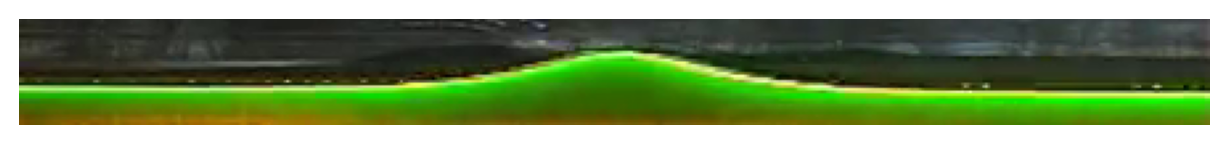

In [25]:
import skimage as img
import imageio.v3 as iio

raw_frames = []
cut = (160,200)
for i in range(200,232):
    frame = iio.imread("youtube_video.mp4",plugin="pyav",index=i)

    # Cut the image to focus only on the wave portion
    raw_frame = frame[cut[0]:cut[1],:,:]
    raw_frames.append(raw_frame)
raw_frames = np.array(raw_frames)
plt.figure(figsize=(8,1))
plt.imshow(raw_frames[16])
plt.axis(False); plt.show()

We then need to remove the background and isolate the wave portion of the image, which is facilitated by the green color of the water in this video:


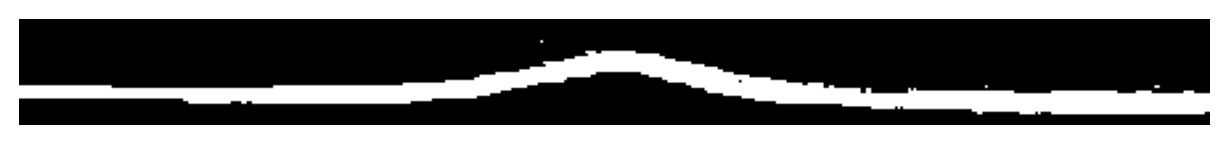

In [26]:
frames = []
for i in range(len(raw_frames)):
    frame = raw_frames[i]

    # Find where the image is more green than red or blue and very bright green
    mean_green = np.mean(frame[:,:,1])
    std_green = np.std(frame[:,:,1])
    frame = (frame[:,:,1] > frame[:,:,0]) & (frame[:,:,1] > frame[:,:,2]) & (frame[:,:,1] > mean_green+std_green)
    frames.append(frame)
frames = np.array(frames)
plt.figure(figsize=(8,1))
plt.imshow(frames[16],cmap="gray")
plt.axis(False); plt.show()

By averaging these pixels across all vertical pixels in the image, we can get a rough wave outline:


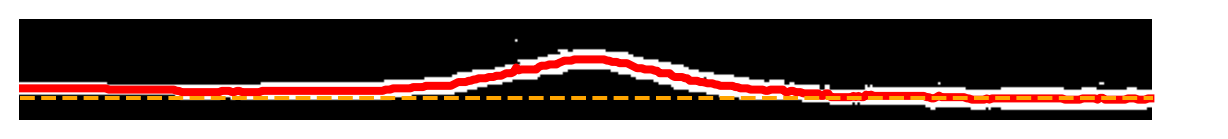

In [27]:
heights = []
for i in range(len(frames)):
    frame = frames[i]
    
    # Approximate wave height by averaging y-locations of bright green areas
    height = np.zeros(frame.shape[1])
    for j in range(frame.shape[1]):
        height[j] = np.mean(np.where(frame[:,j] == 1)[0])
    heights.append(height)
heights = np.array(heights)
base = heights[16, 0]

plt.figure(figsize=(8,1))
plt.imshow(frames[16],cmap="gray")
line = plt.plot(heights[16], color="red",lw=3)[0]
line2 = plt.plot([0,heights.shape[1]], [31,31], color="orange", ls="--")[0]
plt.axis(False); plt.show()

Finally, we can note that the video is not quite level to the wave surface, so we can use a linear adjustment to align the water boundary heights at the middle of the video:

<!-- TODO: Show wave baseline adjustment. -->

In [28]:
# Adjust images and heights for an un-leveled camera
im_width = len(heights[16])
slope = (heights[16][-1] - heights[16][0]) / im_width
for i in range(len(heights)):
    frame = frames[i]
    height = heights[i]

    # Adjust
    for j in range(len(height)):
        shift = int(slope*(im_width-j))
        # Move frame pixels per column
        frame[:,j] = np.roll(frame[:,j], shift)
        # Move height of wave
        height[j] += shift
    frames[i] = frame
    heights[i] = height

frames = np.array(frames)
raw_frames = np.array(raw_frames)
heights = np.array(heights)

fig = plt.figure(figsize=(8,1))
im = plt.imshow(frames[0],cmap="gray")
line = plt.plot(heights[0], color="red",lw=3)[0]
line2 = plt.plot([0,heights.shape[1]], [31,31], color="orange", ls="--")[0]
plt.axis(False);

def animation_function(i):
    im.set_array(frames[i])
    line.set_ydata(heights[i])
    return [im,line,line2]

wave_animation = anim.FuncAnimation(fig, animation_function, frames=range(len(frames)), blit=True)
wave_animation.save("extracted_wave.gif")
plt.close()

![](extracted_wave.gif)

We can now save this data to be used with our previous procedure:

In [29]:
# Video portion is about 2 seconds long
times = np.linspace(0,2,len(heights))
# No given space scale
x_domain = np.arange(len(heights[0]))
np.save("video_wave_images.npy",raw_frames)
np.savez("video_wave_heights.npz",h=heights,x=x_domain,t=times)

### Using our experimental dataset
Using the same methods as listed in @sec-noisy, we can discover an equation for this particular dataset:


In [30]:
x,t,ext_h = load_data("video_wave_heights.npz")
# Flip image wave to be more familiar
ext_h = -ext_h
animation2 = animate_data(x,t,[ext_h], ["extracted h"])
animation2.save("extracted_h.gif")
plt.close()

![](extracted_h.gif)


In [31]:
# Splitting data
X,T = jnp.meshgrid(x,t)
xt_ext = np.vstack((X.flatten(),T.flatten())).T
h_ext = ext_h.flatten()
xt_train, xt_test, h_train, h_test = ms.train_test_split(xt_ext,h_ext,test_size=.1,train_size=.9)
xt_train, xt_valid, h_train, h_valid = ms.train_test_split(xt_train,h_train,test_size=.1,train_size=.9)

train_data = batch_data(xt_train[:,0], xt_train[:,1], h_train, 1000)
valid_data = batch_data(xt_valid[:,0], xt_valid[:,1], h_valid, 1000)
test_data = batch_data(xt_test[:,0], xt_test[:,1], h_test, 1000)

# Initialize model
rng1,rng2 = jax.random.split(jax.random.PRNGKey(42))
random_data = jax.random.normal(rng1,(2,))
model3 = MyNet()
params3 = model3.init(rng2,random_data)

# Loss function
@jax.jit
def mse(params,input,targets):
    def squared_error(x,y):
        pred = model3.apply(params,x)
        return jnp.mean((y - pred)**2)
    return jnp.mean(jax.vmap(squared_error)(input,targets),axis=0)
loss_grad_fn = jax.value_and_grad(mse)

# Optimizer
learning_rate = 1e-2
tx = optax.adam(learning_rate)
opt_state = tx.init(params3)

# Training (adjusted to use our validation data
epochs = 1200
for i in range(epochs):
    xt_batch = train_data[i%len(train_data)][0]
    h_batch = train_data[i%len(train_data)][1]
    loss_val, grads = loss_grad_fn(params3, xt_batch, h_batch)
    updates, opt_state = tx.update(grads, opt_state)
    params3 = optax.apply_updates(params3, updates)
    if i % 100 == 0:
        train_loss = mse(params3,xt_train,h_train)
        valid_loss = mse(params3,xt_valid,h_valid)
        print("Step {}".format(i))
        print("Training loss: {}".format(train_loss))
        print("Validation loss: {}".format(valid_loss))
        print()
test_loss = mse(params3,xt_test,h_test)
print("Test loss after training: {}".format(test_loss))

hhat = model3.apply(params3,xt_ext).reshape(X.shape)
diff = np.sqrt((ext_h - hhat)**2)
animation3 = animate_data(x,t,[ext_h,hhat,diff],["$extracted h$","$\hat{h}$","$L^2$ error"])
animation3.save("ext_h_compare.gif")
plt.close()

Step 0
Training loss: 1.0295377969741821
Validation loss: 1.1295952796936035



Step 100
Training loss: 0.01888686791062355
Validation loss: 0.018603166565299034



Step 200
Training loss: 0.015895208343863487
Validation loss: 0.015097544528543949



Step 300
Training loss: 0.015159177593886852
Validation loss: 0.014175577089190483



Step 400
Training loss: 0.014689643867313862
Validation loss: 0.014466807246208191



Step 500
Training loss: 0.013770081102848053
Validation loss: 0.012997274287045002



Step 600
Training loss: 0.013605344109237194
Validation loss: 0.013018128462135792



Step 700
Training loss: 0.012960381805896759
Validation loss: 0.01260566245764494



Step 800
Training loss: 0.01275940053164959
Validation loss: 0.012205351144075394



Step 900
Training loss: 0.012392761185765266
Validation loss: 0.011866135522723198



Step 1000
Training loss: 0.011908532120287418
Validation loss: 0.011681348085403442



Step 1100
Training loss: 0.011160660535097122
Validation loss: 0.010744725354015827



Test loss after training: 0.01099537406116724


![](ext_h_compare.gif)


In [32]:
def model_for_diff(x,t):
    new_x = jnp.array([x,t])
    return model3.apply(params3, new_x)[0]

# Construct terms numerically
diff_term_values = {}
for i in range(max_diff_order+1):
    diff_func = model_for_diff
    # Iteratively apply derivatives
    for _ in range(i):
        diff_func = jax.grad(diff_func, 0)
    def unpack_diff_func(x):
        new_x,new_t = x
        return diff_func(new_x,new_t)
    diff_term_values[diff_terms[i]] = np.array(jax.lax.map(unpack_diff_func, xt_ext))
term_values = construct_terms(diff_term_values)

def unpack_diff_func(x):
    new_x,new_t = x
    return jax.grad(model_for_diff,1)(new_x,new_t)

h_t_term = sp.Function("h_t")(x_sym,t_sym)
h_t = -np.array(jax.lax.map(unpack_diff_func, xt_ext))

# Forward selection
term_matrix = pd.DataFrame(term_values,index=pd.MultiIndex.from_arrays(np.round(np.array(xt_ext),2).T, names=("x","t")))
forward_r2_select(term_matrix, h_t)

R^2: 0.986532203092632


,"h_x(x, t)"
Coefficients,-0.960688


R^2: 0.9867193762911142


,"h_x(x, t)","h(x, t)*h_x(x, t)"
Coefficients,-0.938803,-0.016764


R^2: 0.9876897491053909


,"h_x(x, t)","h(x, t)*h_x(x, t)","h(x, t)**2*h_x(x, t)"
Coefficients,-0.906299,-0.121123,0.044882


R^2: 0.9890521650070806


,"h_x(x, t)","h(x, t)*h_x(x, t)","h(x, t)**2*h_x(x, t)","h(x, t)**3*h_x(x, t)"
Coefficients,-0.92115,-0.256145,0.242835,-0.06016


Feel free to play with the parameters of each step to try to change/improve the results we have seen here.
